<a href="https://colab.research.google.com/github/pranshudiwan/NLP_CS_6200/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sindhu Baseline LSTM

##Importing Libraries

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wordcloud
!pip install pyspellchecker
from spellchecker import SpellChecker
import math, os, re, time, random, string

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Concatenate, LeakyReLU
from tqdm import tqdm
from collections import defaultdict

import tensorflow as tf

     |████████████████████████████████| 2.7MB 6.6MB/s 


In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

## Downloading Glove words vectors files

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-29 17:44:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-29 17:44:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-29 17:44:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

##Importing train and test data

In [3]:
# Import train data
url_train = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/train.csv'
train = pd.read_csv(url_train)

# Import est data
url_test = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/test.csv'
test   = pd.read_csv(url_test)

##Fill missing values

In [4]:
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

##Single DataFrame

In [5]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

## Visualization
- Class Distribution (number of tweets in each class)
- Number of characters in tweets
- Number of words in tweets
- Average length of word in a tweet

0.0    4342
1.0    3271
Name: target, dtype: int64 



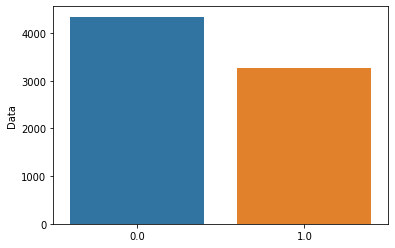

In [6]:
# Class distribution
class_counts=total.target.value_counts()
sns.barplot(x=class_counts.index,y=class_counts)
plt.gca().set_ylabel('Data')

print(class_counts , "\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


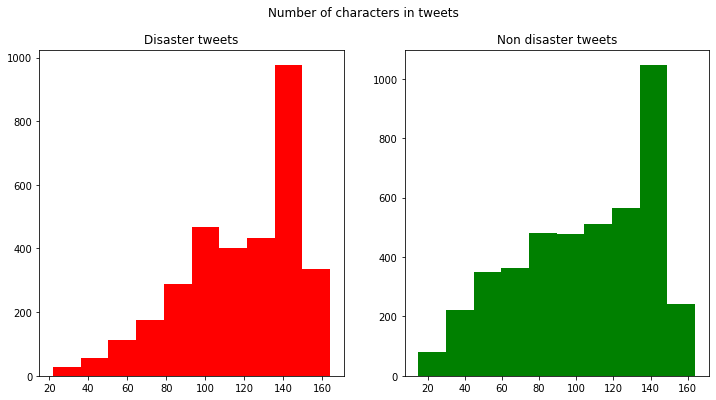

In [7]:
# Number of characters in tweets
train = total[:len(train)]
train['character_count'] = train['text'].apply(lambda word: len(word))


# For Disaster tweets
disaster_tweet_len=train[train['target']==1]['character_count']
#print(disaster_tweet_len)
non_disaster_tweet_len=train[train['target']==0]['character_count']
#print(non_disaster_tweet_len)


# plotting
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_tweet_len,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_tweet_len,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of characters in tweets')
plt.show()

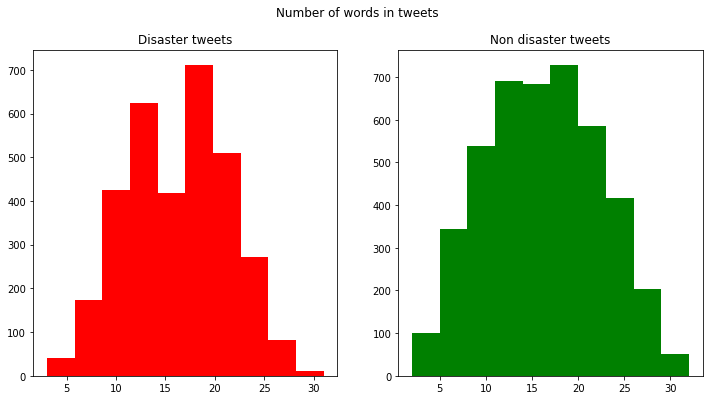

In [8]:
# Number of words in tweets

# For Disaster tweets
disaster_no_of_words=train[train['target']==1]['text'].str.split().map(lambda tweet : len(tweet))
#print(disaster_no_of_words)
non_disaster_no_of_words=train[train['target']==0]['text'].str.split().map(lambda tweet : len(tweet))
#print(non_disaster_no_of_words)


# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_no_of_words,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_no_of_words,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of words in tweets')
plt.show()

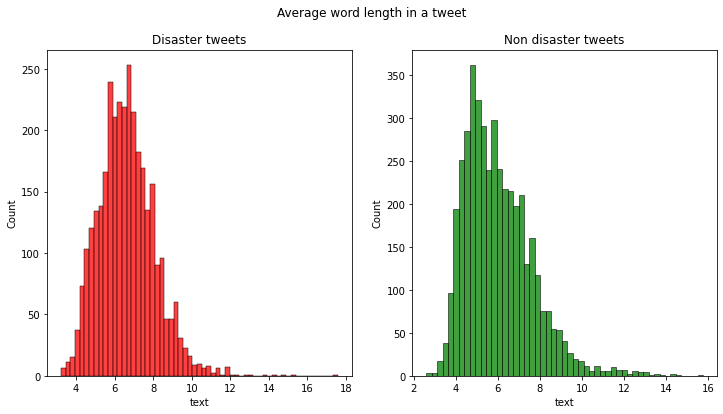

In [9]:
# For Disaster tweets
disaster_word_len=train[train['target']==1]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(disaster_word_len)
#print('Average word length of disaster tweets', disaster_word_len.map(lambda word_len: np.mean(word_len)))
non_disaster_word_len=train[train['target']==0]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(non_disaster_word_len)
#print('Average word length of non disaster tweets', non_disaster_word_len.map(lambda word_len: np.mean(word_len)))

# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
sns.histplot(disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot1,color='red')
subplot1.set_title('Disaster tweets')

sns.histplot(non_disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot2,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Average word length in a tweet')
plt.show()

In [10]:
total.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1.0
1,Forest fire near La Ronge Sask. Canada unknown,1.0
2,All residents asked to 'shelter in place' are ...,1.0
3,"13,000 people receive #wildfires evacuation or...",1.0
4,Just got sent this photo from Ruby #Alaska as ...,1.0


## Data Cleaning for LSTM
- Remove punctuation
- Remove stopwords
- Remove non alphabets
- Remove emojis
- Spellcheck each word
- Expanding all slangs, acronyms and abbreviations

In [ ]:
#@title
def remove_punctuation(data):
    return data.translate(str.maketrans('', '', string.punctuation))

In [ ]:
#@title
def remove_stopwords(data):
    return ' '.join([word for word in data.split() if word not in wordcloud.STOPWORDS]) # using wordcloud stopwords instead of nltk stopwords

In [ ]:
#@title
def remove_non_alphabet(data):
    return ' '.join([word for word in data.split() if word.isalpha()])

In [ ]:
#@title
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
#@title
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
#@title
def expand_slang_abbr_acronyms(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [11]:
total['word count'] = total['text'].apply(lambda x: len(x.split()))
total['character count'] = total['text'].apply(lambda x: len(x))
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

total['average word length'] = total['text'].apply(average_word_length)
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))
total['stopword ratio'] = total['stopword count'] / total['word count']
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

In [ ]:
# CLEAN DATA 

#making the string lower case
total = total.apply(lambda x: x.astype(str).str.lower())
total['text'] = total['text'].apply(remove_punctuation)
total['text'] = total['text'].apply(remove_stopwords)
total['text'] = total['text'].apply(remove_non_alphabet)
#total['text'] = total['text'].apply(correct_spellings)
total['text'] = total['text'].apply(lambda x: remove_emoji(x))
total["text"] = total["text"].apply(lambda x: expand_slang_abbr_acronyms(x))

total.sample(10)

,text,target,word count,character count,average word length,unique word count,stopword count,stopword ratio,punctuation count
580,news fedex longer transport bioterror germs wa...,1.0,21,147,6.0476190476190474,20,4,0.19047619047619047,14
1086,horns you saw beast will hate harlet make deso...,nan,29,142,3.9310344827586206,23,13,0.4482758620689655,0
7526,wreckage conclusively confirmed malaysia prime...,1.0,18,145,7.111111111111111,18,7,0.3888888888888889,12
1798,ill crash crash,1.0,6,51,7.666666666666667,5,2,0.3333333333333333,5
2407,still wonder will anything life anywhere wars ...,nan,22,149,5.818181818181818,21,6,0.2727272727272727,8
6252,liked youtube video boeing takeoff snowstorm h...,1.0,21,131,5.285714285714286,21,3,0.14285714285714285,9
5695,young children among rescued capsized boat lib...,1.0,14,115,7.285714285714286,13,3,0.21428571428571427,6
6399,isis claims responsibility saudi mosque suicid...,1.0,11,122,10.181818181818182,11,1,0.09090909090909091,11
2674,spinningbot another standuser will detonate ki...,0.0,19,110,4.842105263157895,16,11,0.5789473684210527,4
6832,trapped disappearance trapped,0.0,5,36,6.4,4,2,0.4,0


## Simple LSTM


In [12]:
tweets = [tweet for tweet in total['text']]

train = total[:len(train)]
test = total[len(train):]

In [13]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.preprocessing.text import Tokenizer


#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29349 unique tokens.
Shape of data tensor: (10876, 35)
Shape of label tensor: (7613,)


In [14]:
#get GloVe vector embeddings
embeddings_index = {}
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:23, 17234.01it/s]

Found 400000 word vectors in the GloVe library


In [15]:
EMBEDDING_DIM = 200

In [16]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29349/29349 [00:00<00:00, 501195.51it/s]

Our embedded matrix is of dimension (29350, 200)


In [17]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
train.head()
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    #meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(nlp_out)
    
    #compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', f1_m,precision_m, recall_m])
    
    return model

In [25]:
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2, learning_rate = 3e-4, bidirectional = False)
lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nlp_input (InputLayer)       [(None, 35)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 35, 200)           5870000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 35, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5,990,501
Trainable params: 120,501
Non-trainable params: 5,870,000
_________________________________________________________________


In [26]:
history1 = lstm.fit([nlp_train], labels, validation_split = .2, epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 24s 73ms/step - loss: 0.5990 - accuracy: 0.6655 - f1_m: 0.5876 - precision_m: 0.6385 - recall_m: 0.6006 - val_loss: 0.4385 - val_accuracy: 0.8070 - val_f1_m: 0.5709 - val_precision_m: 0.7296 - val_recall_m: 0.5045
Epoch 2/5
290/290 [==============================] - 21s 72ms/step - loss: 0.4596 - accuracy: 0.7951 - f1_m: 0.7174 - precision_m: 0.8028 - recall_m: 0.6740 - val_loss: 0.4114 - val_accuracy: 0.8214 - val_f1_m: 0.6236 - val_precision_m: 0.7234 - val_recall_m: 0.5792
Epoch 3/5
290/290 [==============================] - 21s 71ms/step - loss: 0.4340 - accuracy: 0.8039 - f1_m: 0.7446 - precision_m: 0.8121 - recall_m: 0.7123 - val_loss: 0.4126 - val_accuracy: 0.8181 - val_f1_m: 0.5908 - val_precision_m: 0.7489 - val_recall_m: 0.5244
Epoch 4/5
290/290 [==============================] - 21s 71ms/step - loss: 0.4320 - accuracy: 0.8060 - f1_m: 0.7396 - precision_m: 0.8219 - recall_m: 0.6960 - val_loss: 0.4337 - val_accuracy: 0.8011 